# Supervised Contrastive Learning for OCT Encoder Pretraining
## v3: Anti-Overfitting Version with Linear Probe Evaluation

### 核心改进 (解决过拟合):
1. **Linear Probe / kNN 评估**: 用下游任务性能选择checkpoint（而非SupCon loss）
2. **Early Stopping**: 基于validation下游性能提前停止
3. **混合目标**: SupCon + SimCLR loss，防止label过拟合
4. **降低锐度**: temperature 0.07→0.2, projection head加dropout
5. **增强正则化**: weight decay增大，更强的数据增强

### 关键insight:
- SupCon validation loss **不能**反映表示质量
- 对比学习应该用**下游任务性能**来评估和选择模型
- 小数据集上，早停和正则化至关重要

---
## 1. Environment Setup and Configuration

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.0.1
CUDA available: True
CUDA version: 11.7
GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.76 GB


In [2]:
# ============================================================
# CONFIGURATION - Anti-Overfitting Settings
# ============================================================

SEED = 42

# Paths
DATA_ROOT = "./Prime Images"
BIOMARKER_CSV = './2_biomarker_processed.csv'
OUTPUT_DIR = './supcon_output_v3'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# ============================================================
# KEY ANTI-OVERFITTING HYPERPARAMETERS
# ============================================================
BATCH_SIZE = 256
NUM_EPOCHS = 100              # 减少最大epoch数
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4           # 增大: 1e-4 → 5e-4

# SupCon specific - 降低锐度
TEMPERATURE = 0.2             # 提高: 0.07 → 0.2 (更平滑的分布)
EMBEDDING_DIM = 256
PROJECTION_DIM = 64           # 减小: 128 → 64
PROJECTION_DROPOUT = 0.3      # 新增: projection head dropout

# 混合损失
USE_HYBRID_LOSS = True        # 是否使用 SupCon + SimCLR 混合
SIMCLR_WEIGHT = 0.3           # SimCLR loss 权重 (SupCon权重 = 1 - SIMCLR_WEIGHT)

# Early Stopping - 基于下游性能
EVAL_EVERY = 5                # 每5个epoch评估一次
PATIENCE = 10                 # early stopping patience (以EVAL_EVERY为单位)
MIN_EPOCHS = 10               # 最少训练epoch数

# Other
IMAGE_SIZE = 224
CHECKPOINT_EVERY = 10
KEEP_LAST_N_CHECKPOINTS = 5
RESUME_TRAINING = False       # 新训练，不resume

# Test mode
TEST_MODE = False
TEST_SAMPLES = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')

print(f"\n{'='*60}")
print("ANTI-OVERFITTING CONFIGURATION")
print(f"{'='*60}")
print(f"Temperature: {TEMPERATURE} (higher = smoother)")
print(f"Projection Dim: {PROJECTION_DIM} (smaller = less capacity)")
print(f"Projection Dropout: {PROJECTION_DROPOUT}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Hybrid Loss (SupCon + SimCLR): {USE_HYBRID_LOSS}")
if USE_HYBRID_LOSS:
    print(f"  SimCLR Weight: {SIMCLR_WEIGHT}")
print(f"Early Stopping Patience: {PATIENCE} (x {EVAL_EVERY} epochs)")
print(f"{'='*60}")


Using device: cuda

ANTI-OVERFITTING CONFIGURATION
Temperature: 0.2 (higher = smoother)
Projection Dim: 64 (smaller = less capacity)
Projection Dropout: 0.3
Weight Decay: 0.0005
Hybrid Loss (SupCon + SimCLR): True
  SimCLR Weight: 0.3
Early Stopping Patience: 10 (x 5 epochs)


In [3]:
# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_random_states():
    return {
        'python': random.getstate(),
        'numpy': np.random.get_state(),
        'torch': torch.get_rng_state(),
        'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    }

def set_random_states(states):
    random.setstate(states['python'])
    np.random.set_state(states['numpy'])
    torch.set_rng_state(states['torch'])
    if states['cuda'] is not None and torch.cuda.is_available():
        torch.cuda.set_rng_state_all(states['cuda'])

set_seed(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 42


---
## 2. Data Loading and Preprocessing

In [4]:
biomarker_df = pd.read_csv(BIOMARKER_CSV)
print(f"Loaded {len(biomarker_df)} B-scan records")

# Selected biomarkers
SELECTED_BIOMARKERS = [
    'IR HRF', 'Fully attached vitreous face', 'Vitreous debris',
    'Partially attached vitreous face', 'Fluid (IRF)', 'DRT/ME'
]

# Create labels
def create_biomarker_label(row, biomarker_cols):
    return '_'.join([str(int(row[col])) for col in biomarker_cols])

biomarker_df['label_str'] = biomarker_df.apply(
    lambda row: create_biomarker_label(row, SELECTED_BIOMARKERS), axis=1
)

label_counts = biomarker_df['label_str'].value_counts()
label_to_idx = {label: idx for idx, label in enumerate(label_counts.index)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
biomarker_df['label_idx'] = biomarker_df['label_str'].map(label_to_idx)

print(f'Created {len(label_to_idx)} unique biomarker combination labels')

Loaded 3920 B-scan records
Created 48 unique biomarker combination labels


In [5]:
# Patient-level train/val split
patients = biomarker_df['Patient_ID_String'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=SEED)

train_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(train_patients)].copy()
val_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(val_patients)].copy()

if TEST_MODE:
    train_df = train_df.sample(n=min(TEST_SAMPLES, len(train_df)), random_state=SEED)
    val_df = val_df.sample(n=min(TEST_SAMPLES // 5, len(val_df)), random_state=SEED)

print(f'Train: {len(train_df)} samples from {len(train_patients)} patients')
print(f'Val: {len(val_df)} samples from {len(val_patients)} patients')

Train: 3136 samples from 32 patients
Val: 784 samples from 8 patients


---
## 3. Dataset and DataLoader (更强的数据增强)

In [6]:
# 更强的数据增强 - 防止过拟合
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),                    # 新增
    transforms.RandomAffine(
        degrees=15,                                          # 增大: 10 → 15
        translate=(0.15, 0.15),                              # 增大: 0.1 → 0.15
        scale=(0.85, 1.15)                                   # 增大范围
    ),
    transforms.ColorJitter(
        brightness=0.3,                                      # 增大: 0.2 → 0.3
        contrast=0.3,
        saturation=0.1,                                      # 新增
    ),
    transforms.RandomGrayscale(p=0.1),                       # 新增
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),# 新增
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))      # 新增
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Enhanced data augmentation configured")

Enhanced data augmentation configured


In [7]:
class OCTSupConDataset(Dataset):
    """Dataset for SupCon - returns two augmented views."""
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        
        if self.transform:
            view1 = self.transform(image)
            view2 = self.transform(image)
            return view1, view2, label
        return image, image, label


class OCTValDataset(Dataset):
    """Validation dataset - single view for linear probe."""
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Create datasets
train_dataset = OCTSupConDataset(train_df, DATA_ROOT, transform=train_transform)
val_dataset = OCTValDataset(val_df, DATA_ROOT, transform=val_transform)
# 用于linear probe的训练集（无增强）
train_eval_dataset = OCTValDataset(train_df, DATA_ROOT, transform=val_transform)

num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=num_workers, pin_memory=True)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=num_workers, pin_memory=True)

print(f'Train loader: {len(train_loader)} batches')
print(f'Val loader: {len(val_loader)} batches')

Train loader: 12 batches
Val loader: 4 batches


---
## 4. Model Architecture (带Dropout的Projection Head)

In [9]:
class OCTEncoder(nn.Module):
    """ResNet-18 based encoder."""
    def __init__(self, embedding_dim=256, pretrained=True):
        super(OCTEncoder, self).__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )
        self.embedding_dim = embedding_dim
        
    def forward(self, x):
        embedding = self.backbone(x)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding


class ProjectionHead(nn.Module):
    """Projection head with dropout for regularization."""
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=64, dropout=0.3):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),           # 新增 BatchNorm
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),                # 新增 Dropout
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        z = self.projection(x)
        z = F.normalize(z, p=2, dim=1)
        return z


class SupConModel(nn.Module):
    """Complete model with regularized projection head."""
    def __init__(self, embedding_dim=256, projection_dim=64, dropout=0.3, pretrained=True):
        super(SupConModel, self).__init__()
        self.encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=pretrained)
        self.projection_head = ProjectionHead(
            input_dim=embedding_dim,
            hidden_dim=embedding_dim,
            output_dim=projection_dim,
            dropout=dropout
        )
        
    def forward(self, x):
        embedding = self.encoder(x)
        z = self.projection_head(embedding)
        return embedding, z
    
    def get_embedding(self, x):
        return self.encoder(x)

In [10]:
# Initialize model with anti-overfitting settings
model = SupConModel(
    embedding_dim=EMBEDDING_DIM,
    projection_dim=PROJECTION_DIM,     # 64 instead of 128
    dropout=PROJECTION_DROPOUT,        # 0.3
    pretrained=True
).to(device)

print('Model Architecture:')
print(f'  Embedding dim: {EMBEDDING_DIM}')
print(f'  Projection dim: {PROJECTION_DIM}')
print(f'  Projection dropout: {PROJECTION_DROPOUT}')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

Model Architecture:
  Embedding dim: 256
  Projection dim: 64
  Projection dropout: 0.3
Total parameters: 11,653,248


---
## 5. Loss Functions (SupCon + SimCLR Hybrid)

In [11]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Loss with higher temperature."""
    def __init__(self, temperature=0.2):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        device = features.device
        batch_size = labels.shape[0]
        
        labels = labels.contiguous().view(-1, 1)
        labels = torch.cat([labels, labels], dim=0)
        
        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        logits = similarity_matrix / self.temperature
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum > 0, mask_sum, torch.ones_like(mask_sum))
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask_sum
        
        loss = -mean_log_prob_pos.mean()
        return loss


class SimCLRLoss(nn.Module):
    """SimCLR (self-supervised) contrastive loss - 不依赖标签."""
    def __init__(self, temperature=0.2):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels=None):  # labels参数忽略
        """features: [2*B, D] - view1和view2拼接"""
        device = features.device
        batch_size = features.shape[0] // 2
        
        # 创建正样本对mask: 只有(i, i+B)和(i+B, i)是正样本对
        labels_simclr = torch.arange(batch_size).to(device)
        labels_simclr = torch.cat([labels_simclr, labels_simclr], dim=0)
        
        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eq(labels_simclr.view(-1, 1), labels_simclr.view(1, -1)).float()
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        logits = similarity_matrix / self.temperature
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        loss = -mean_log_prob_pos.mean()
        return loss


class HybridContrastiveLoss(nn.Module):
    """SupCon + SimCLR混合损失 - 防止label过拟合."""
    def __init__(self, temperature=0.2, simclr_weight=0.3):
        super(HybridContrastiveLoss, self).__init__()
        self.supcon_loss = SupConLoss(temperature=temperature)
        self.simclr_loss = SimCLRLoss(temperature=temperature)
        self.simclr_weight = simclr_weight
        
    def forward(self, features, labels):
        supcon = self.supcon_loss(features, labels)
        simclr = self.simclr_loss(features)
        
        loss = (1 - self.simclr_weight) * supcon + self.simclr_weight * simclr
        return loss, supcon.item(), simclr.item()

In [12]:
# Initialize loss
if USE_HYBRID_LOSS:
    criterion = HybridContrastiveLoss(temperature=TEMPERATURE, simclr_weight=SIMCLR_WEIGHT)
    print(f"Using Hybrid Loss: {1-SIMCLR_WEIGHT:.0%} SupCon + {SIMCLR_WEIGHT:.0%} SimCLR")
else:
    criterion = SupConLoss(temperature=TEMPERATURE)
    print(f"Using SupCon Loss only")
print(f"Temperature: {TEMPERATURE}")

Using Hybrid Loss: 70% SupCon + 30% SimCLR
Temperature: 0.2


---
## 6. 下游任务评估 (Linear Probe & kNN)

**关键**: 对比学习应该用下游任务性能来评估表示质量，而不是SupCon loss！

In [13]:
def extract_embeddings(model, dataloader, device):
    """Extract embeddings from encoder (frozen)."""
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            emb = model.get_embedding(images)
            embeddings.append(emb.cpu().numpy())
            labels.append(batch_labels.numpy())
    
    return np.vstack(embeddings), np.concatenate(labels)


def evaluate_linear_probe(train_embeddings, train_labels, val_embeddings, val_labels, 
                          max_iter=1000, C=1.0):
    """
    Linear Probe评估: 冻结encoder，训练线性分类器。
    这是评估对比学习表示质量的标准方法。
    
    Returns:
        accuracy: 分类准确率
        auroc: 如果类别数允许，返回AUROC (否则返回None)
    """
    # 训练线性分类器
    clf = LogisticRegression(
        max_iter=max_iter,
        C=C,
        solver='lbfgs',
        multi_class='multinomial',
        random_state=42,
        n_jobs=-1
    )
    
    # 只用出现在训练集中的类别
    unique_train_labels = np.unique(train_labels)
    
    clf.fit(train_embeddings, train_labels)
    
    # 预测
    val_preds = clf.predict(val_embeddings)
    accuracy = accuracy_score(val_labels, val_preds)
    
    # 尝试计算AUROC (如果类别数合适)
    auroc = None
    try:
        if len(unique_train_labels) > 2:
            val_probs = clf.predict_proba(val_embeddings)
            # 只计算训练集中出现的类别
            val_labels_bin = label_binarize(val_labels, classes=clf.classes_)
            auroc = roc_auc_score(val_labels_bin, val_probs, multi_class='ovr', average='macro')
    except:
        pass
    
    return accuracy, auroc


def evaluate_knn(train_embeddings, train_labels, val_embeddings, val_labels, k=5):
    """
    kNN评估: 不需要训练，直接评估embedding的聚类质量。
    更快速，适合频繁评估。
    """
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
    knn.fit(train_embeddings, train_labels)
    
    val_preds = knn.predict(val_embeddings)
    accuracy = accuracy_score(val_labels, val_preds)
    
    return accuracy


def evaluate_representation_quality(model, train_eval_loader, val_loader, device):
    """
    综合评估表示质量。
    Returns dict with linear_probe_acc, knn_acc, auroc
    """
    # Extract embeddings
    train_emb, train_labels = extract_embeddings(model, train_eval_loader, device)
    val_emb, val_labels = extract_embeddings(model, val_loader, device)
    
    # Linear Probe
    lp_acc, auroc = evaluate_linear_probe(train_emb, train_labels, val_emb, val_labels)
    
    # kNN
    knn_acc = evaluate_knn(train_emb, train_labels, val_emb, val_labels, k=5)
    
    return {
        'linear_probe_acc': lp_acc,
        'knn_acc': knn_acc,
        'auroc': auroc
    }

print("Evaluation functions defined!")
print("  - evaluate_linear_probe(): 线性探针评估")
print("  - evaluate_knn(): kNN评估")
print("  - evaluate_representation_quality(): 综合评估")

Evaluation functions defined!
  - evaluate_linear_probe(): 线性探针评估
  - evaluate_knn(): kNN评估
  - evaluate_representation_quality(): 综合评估


---
## 7. Checkpointing and Early Stopping

In [14]:
class CheckpointManager:
    """Checkpoint manager."""
    def __init__(self, checkpoint_dir, keep_last_n=5):
        self.checkpoint_dir = checkpoint_dir
        self.keep_last_n = keep_last_n
        os.makedirs(checkpoint_dir, exist_ok=True)
        
    def save_checkpoint(self, state, epoch, is_best=False, filename=None):
        if filename is None:
            filename = f'checkpoint_epoch_{epoch:04d}.pth'
        filepath = os.path.join(self.checkpoint_dir, filename)
        state['checkpoint_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        state['epoch'] = epoch
        torch.save(state, filepath)
        print(f"  ✓ Checkpoint saved: {filename}")
        
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(state, best_path)
            print(f"  ✓ Best model updated!")
        self._cleanup()
        
    def _cleanup(self):
        checkpoints = sorted([f for f in os.listdir(self.checkpoint_dir)
                             if f.startswith('checkpoint_epoch_') and f.endswith('.pth')])
        if len(checkpoints) > self.keep_last_n:
            for ckpt in checkpoints[:-self.keep_last_n]:
                os.remove(os.path.join(self.checkpoint_dir, ckpt))
    
    def load_latest(self):
        checkpoints = sorted([f for f in os.listdir(self.checkpoint_dir)
                             if f.startswith('checkpoint_epoch_') and f.endswith('.pth')])
        if not checkpoints:
            return None
        return torch.load(os.path.join(self.checkpoint_dir, checkpoints[-1]), map_location=device)
    
    def load_best(self):
        best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
        if not os.path.exists(best_path):
            return None
        return torch.load(best_path, map_location=device)


class EarlyStopping:
    """Early stopping based on downstream task performance (NOT SupCon loss)."""
    def __init__(self, patience=10, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return True  # is_best
        
        if self.mode == 'max':
            improved = score > self.best_score + self.min_delta
        else:
            improved = score < self.best_score - self.min_delta
            
        if improved:
            self.best_score = score
            self.counter = 0
            return True  # is_best
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False  # not best


class TrainingLogger:
    def __init__(self, output_dir):
        self.log_path = os.path.join(output_dir, 'training_log.csv')
        self.logs = []
        if os.path.exists(self.log_path):
            self.logs = pd.read_csv(self.log_path).to_dict('records')
    
    def log(self, **kwargs):
        kwargs['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        self.logs.append(kwargs)
        pd.DataFrame(self.logs).to_csv(self.log_path, index=False)
    
    def get_history(self):
        return pd.DataFrame(self.logs)


checkpoint_manager = CheckpointManager(CHECKPOINT_DIR, keep_last_n=KEEP_LAST_N_CHECKPOINTS)
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.001, mode='max')
training_logger = TrainingLogger(OUTPUT_DIR)

print(f"Early stopping: patience={PATIENCE}, based on linear probe accuracy")

Early stopping: patience=10, based on linear probe accuracy


---
## 8. Training Functions

In [15]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler, use_hybrid=False):
    """Train for one epoch with mixed precision."""
    model.train()
    total_loss = 0
    supcon_losses = []
    simclr_losses = []
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for view1, view2, labels in pbar:
        view1 = view1.to(device, non_blocking=True)
        view2 = view2.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        images = torch.cat([view1, view2], dim=0)
        
        with torch.cuda.amp.autocast():
            _, z = model(images)
            if use_hybrid:
                loss, supcon_l, simclr_l = criterion(z, labels)
                supcon_losses.append(supcon_l)
                simclr_losses.append(simclr_l)
            else:
                loss = criterion(z, labels)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    result = {'total_loss': avg_loss}
    if use_hybrid and supcon_losses:
        result['supcon_loss'] = np.mean(supcon_losses)
        result['simclr_loss'] = np.mean(simclr_losses)
    return result

---
## 9. Main Training Loop

In [16]:
# ============================================================
# Main Training Loop with Linear Probe Evaluation
# ============================================================

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training state
train_losses = []
eval_history = []  # 保存每次evaluation的结果
best_lp_acc = 0.0

print('='*70)
print('TRAINING WITH LINEAR PROBE EVALUATION')
print('='*70)
print(f'Evaluation every {EVAL_EVERY} epochs')
print(f'Early stopping patience: {PATIENCE} (based on linear probe acc)')
print('='*70)

try:
    for epoch in range(NUM_EPOCHS):
        epoch_start = datetime.now()
        current_lr = scheduler.get_last_lr()[0]
        
        print(f'\n{"="*70}')
        print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | LR: {current_lr:.6f}')
        print(f'{"="*70}')
        
        # Train
        train_result = train_one_epoch(model, train_loader, criterion, optimizer, 
                                       device, epoch, scaler, use_hybrid=USE_HYBRID_LOSS)
        train_losses.append(train_result['total_loss'])
        scheduler.step()
        
        # Print training stats
        print(f'\n  Train Loss: {train_result["total_loss"]:.4f}')
        if USE_HYBRID_LOSS and 'supcon_loss' in train_result:
            print(f'    SupCon: {train_result["supcon_loss"]:.4f}, SimCLR: {train_result["simclr_loss"]:.4f}')
        
        # ============================================================
        # 关键: 用Linear Probe评估表示质量
        # ============================================================
        is_best = False
        if (epoch + 1) % EVAL_EVERY == 0 or (epoch + 1) == NUM_EPOCHS:
            print(f'\n  Evaluating representation quality...')
            eval_result = evaluate_representation_quality(model, train_eval_loader, val_loader, device)
            
            lp_acc = eval_result['linear_probe_acc']
            knn_acc = eval_result['knn_acc']
            auroc = eval_result['auroc']
            
            eval_history.append({
                'epoch': epoch + 1,
                'linear_probe_acc': lp_acc,
                'knn_acc': knn_acc,
                'auroc': auroc,
                'train_loss': train_result['total_loss']
            })
            
            print(f'  📊 Linear Probe Acc: {lp_acc:.4f}')
            print(f'  📊 kNN Acc: {knn_acc:.4f}')
            if auroc:
                print(f'  📊 AUROC: {auroc:.4f}')
            
            # Early stopping check (基于linear probe accuracy)
            is_best = early_stopping(lp_acc)
            if is_best:
                best_lp_acc = lp_acc
                print(f'  ✨ New best! LP Acc: {best_lp_acc:.4f}')
            
            if early_stopping.early_stop and (epoch + 1) >= MIN_EPOCHS:
                print(f'\n⚠️ Early stopping triggered! No improvement for {PATIENCE} evaluations.')
                break
        
        # Log
        training_logger.log(
            epoch=epoch + 1,
            train_loss=train_result['total_loss'],
            linear_probe_acc=eval_history[-1]['linear_probe_acc'] if eval_history else None,
            knn_acc=eval_history[-1]['knn_acc'] if eval_history else None,
            lr=current_lr,
            best_lp_acc=best_lp_acc
        )
        
        # Save checkpoint
        if (epoch + 1) % CHECKPOINT_EVERY == 0 or is_best or (epoch + 1) == NUM_EPOCHS:
            checkpoint_state = {
                'model_state_dict': model.state_dict(),
                'encoder_state_dict': model.encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'train_loss': train_result['total_loss'],
                'best_lp_acc': best_lp_acc,
                'train_losses': train_losses,
                'eval_history': eval_history,
                'random_states': get_random_states(),
            }
            checkpoint_manager.save_checkpoint(checkpoint_state, epoch + 1, is_best)
        
        epoch_time = (datetime.now() - epoch_start).total_seconds() / 60
        print(f'  Time: {epoch_time:.2f} min')
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print('\n\nTraining interrupted! Saving checkpoint...')
    checkpoint_manager.save_checkpoint({
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'epoch': epoch,
        'train_losses': train_losses,
        'eval_history': eval_history,
        'best_lp_acc': best_lp_acc,
    }, epoch + 1, filename='checkpoint_interrupted.pth')

print('\n' + '='*70)
print('TRAINING COMPLETE!')
print(f'Best Linear Probe Accuracy: {best_lp_acc:.4f}')
print('='*70)

TRAINING WITH LINEAR PROBE EVALUATION
Evaluation every 5 epochs
Early stopping patience: 10 (based on linear probe acc)

Epoch 1/100 | LR: 0.001000


Epoch 0: 100%|██████████| 12/12 [00:38<00:00,  3.17s/it, loss=5.8483]



  Train Loss: 6.0680
    SupCon: 6.2565, SimCLR: 5.6281
  Time: 0.63 min

Epoch 2/100 | LR: 0.001000


Epoch 1: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=5.4612]



  Train Loss: 5.6304
    SupCon: 5.9795, SimCLR: 4.8159
  Time: 0.73 min

Epoch 3/100 | LR: 0.000999


Epoch 2: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it, loss=5.3465]



  Train Loss: 5.3757
    SupCon: 5.8364, SimCLR: 4.3007
  Time: 0.72 min

Epoch 4/100 | LR: 0.000998


Epoch 3: 100%|██████████| 12/12 [00:37<00:00,  3.14s/it, loss=5.2320]



  Train Loss: 5.2194
    SupCon: 5.7161, SimCLR: 4.0605
  Time: 0.63 min

Epoch 5/100 | LR: 0.000996


Epoch 4: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it, loss=4.9479]



  Train Loss: 5.0591
    SupCon: 5.5576, SimCLR: 3.8959

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.2985
  📊 kNN Acc: 0.2781
  ✨ New best! LP Acc: 0.2985
  ✓ Checkpoint saved: checkpoint_epoch_0005.pth
  ✓ Best model updated!
  Time: 0.94 min

Epoch 6/100 | LR: 0.000994


Epoch 5: 100%|██████████| 12/12 [00:45<00:00,  3.75s/it, loss=4.8579]



  Train Loss: 4.9529
    SupCon: 5.4573, SimCLR: 3.7759
  Time: 0.75 min

Epoch 7/100 | LR: 0.000991


Epoch 6: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it, loss=4.9070]



  Train Loss: 4.8670
    SupCon: 5.3529, SimCLR: 3.7332
  Time: 0.72 min

Epoch 8/100 | LR: 0.000988


Epoch 7: 100%|██████████| 12/12 [00:43<00:00,  3.67s/it, loss=4.7142]



  Train Loss: 4.8023
    SupCon: 5.2817, SimCLR: 3.6837
  Time: 0.73 min

Epoch 9/100 | LR: 0.000984


Epoch 8: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=4.7239]



  Train Loss: 4.7486
    SupCon: 5.2162, SimCLR: 3.6574
  Time: 0.73 min

Epoch 10/100 | LR: 0.000980


Epoch 9: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it, loss=4.6707]



  Train Loss: 4.7063
    SupCon: 5.1629, SimCLR: 3.6407

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3265
  📊 kNN Acc: 0.2908
  ✨ New best! LP Acc: 0.3265
  ✓ Checkpoint saved: checkpoint_epoch_0010.pth
  ✓ Best model updated!
  Time: 0.91 min

Epoch 11/100 | LR: 0.000976


Epoch 10: 100%|██████████| 12/12 [00:41<00:00,  3.50s/it, loss=4.5670]



  Train Loss: 4.6346
    SupCon: 5.1017, SimCLR: 3.5449
  Time: 0.70 min

Epoch 12/100 | LR: 0.000970


Epoch 11: 100%|██████████| 12/12 [00:42<00:00,  3.53s/it, loss=4.5930]



  Train Loss: 4.6161
    SupCon: 5.0629, SimCLR: 3.5735
  Time: 0.71 min

Epoch 13/100 | LR: 0.000965


Epoch 12: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it, loss=4.5315]



  Train Loss: 4.5586
    SupCon: 4.9951, SimCLR: 3.5399
  Time: 0.72 min

Epoch 14/100 | LR: 0.000959


Epoch 13: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it, loss=4.5348]



  Train Loss: 4.5447
    SupCon: 4.9764, SimCLR: 3.5373
  Time: 0.72 min

Epoch 15/100 | LR: 0.000952


Epoch 14: 100%|██████████| 12/12 [00:43<00:00,  3.66s/it, loss=4.4321]



  Train Loss: 4.5205
    SupCon: 4.9616, SimCLR: 3.4915

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3406
  📊 kNN Acc: 0.2781
  ✨ New best! LP Acc: 0.3406
  ✓ Checkpoint saved: checkpoint_epoch_0015.pth
  ✓ Best model updated!
  Time: 0.92 min

Epoch 16/100 | LR: 0.000946


Epoch 15: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it, loss=4.4895]



  Train Loss: 4.4989
    SupCon: 4.9291, SimCLR: 3.4950
  Time: 0.72 min

Epoch 17/100 | LR: 0.000938


Epoch 16: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it, loss=4.4564]



  Train Loss: 4.4761
    SupCon: 4.8923, SimCLR: 3.5047
  Time: 0.72 min

Epoch 18/100 | LR: 0.000930


Epoch 17: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it, loss=4.4339]



  Train Loss: 4.4280
    SupCon: 4.8470, SimCLR: 3.4504
  Time: 0.75 min

Epoch 19/100 | LR: 0.000922


Epoch 18: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it, loss=4.3793]



  Train Loss: 4.4089
    SupCon: 4.8131, SimCLR: 3.4658
  Time: 0.72 min

Epoch 20/100 | LR: 0.000914


Epoch 19: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it, loss=4.4194]



  Train Loss: 4.4010
    SupCon: 4.8177, SimCLR: 3.4285

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3559
  📊 kNN Acc: 0.3495
  ✨ New best! LP Acc: 0.3559
  ✓ Checkpoint saved: checkpoint_epoch_0020.pth
  ✓ Best model updated!
  Time: 0.93 min

Epoch 21/100 | LR: 0.000905


Epoch 20: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it, loss=4.3261]



  Train Loss: 4.3571
    SupCon: 4.7594, SimCLR: 3.4185
  Time: 0.72 min

Epoch 22/100 | LR: 0.000895


Epoch 21: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it, loss=4.2877]



  Train Loss: 4.3354
    SupCon: 4.7242, SimCLR: 3.4282
  Time: 0.76 min

Epoch 23/100 | LR: 0.000885


Epoch 22: 100%|██████████| 12/12 [00:41<00:00,  3.50s/it, loss=4.3546]



  Train Loss: 4.3395
    SupCon: 4.7368, SimCLR: 3.4123
  Time: 0.70 min

Epoch 24/100 | LR: 0.000875


Epoch 23: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it, loss=4.2631]



  Train Loss: 4.3082
    SupCon: 4.6969, SimCLR: 3.4013
  Time: 0.72 min

Epoch 25/100 | LR: 0.000865


Epoch 24: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it, loss=4.3541]



  Train Loss: 4.2830
    SupCon: 4.6702, SimCLR: 3.3795

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3661
  📊 kNN Acc: 0.3329
  ✨ New best! LP Acc: 0.3661
  ✓ Checkpoint saved: checkpoint_epoch_0025.pth
  ✓ Best model updated!
  Time: 0.95 min

Epoch 26/100 | LR: 0.000854


Epoch 25: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it, loss=4.2683]



  Train Loss: 4.2744
    SupCon: 4.6444, SimCLR: 3.4109
  Time: 0.76 min

Epoch 27/100 | LR: 0.000842


Epoch 26: 100%|██████████| 12/12 [00:44<00:00,  3.75s/it, loss=4.2878]



  Train Loss: 4.2529
    SupCon: 4.6395, SimCLR: 3.3510
  Time: 0.75 min

Epoch 28/100 | LR: 0.000831


Epoch 27: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=4.2235]



  Train Loss: 4.2457
    SupCon: 4.6228, SimCLR: 3.3660
  Time: 0.73 min

Epoch 29/100 | LR: 0.000819


Epoch 28: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it, loss=4.2245]



  Train Loss: 4.2251
    SupCon: 4.5957, SimCLR: 3.3602
  Time: 0.76 min

Epoch 30/100 | LR: 0.000807


Epoch 29: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it, loss=4.2312]



  Train Loss: 4.1972
    SupCon: 4.5698, SimCLR: 3.3280

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3482
  📊 kNN Acc: 0.3240
  ✓ Checkpoint saved: checkpoint_epoch_0030.pth
  Time: 0.92 min

Epoch 31/100 | LR: 0.000794


Epoch 30: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it, loss=4.2591]



  Train Loss: 4.1693
    SupCon: 4.5262, SimCLR: 3.3365
  Time: 0.76 min

Epoch 32/100 | LR: 0.000781


Epoch 31: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it, loss=4.1250]



  Train Loss: 4.1598
    SupCon: 4.5112, SimCLR: 3.3399
  Time: 0.76 min

Epoch 33/100 | LR: 0.000768


Epoch 32: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it, loss=4.0893]



  Train Loss: 4.1343
    SupCon: 4.4878, SimCLR: 3.3097
  Time: 0.79 min

Epoch 34/100 | LR: 0.000755


Epoch 33: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it, loss=4.1944]



  Train Loss: 4.1233
    SupCon: 4.4762, SimCLR: 3.3001
  Time: 0.80 min

Epoch 35/100 | LR: 0.000741


Epoch 34: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it, loss=4.0817]



  Train Loss: 4.0879
    SupCon: 4.4187, SimCLR: 3.3161

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.2921
  📊 kNN Acc: 0.2870
  Time: 0.98 min

Epoch 36/100 | LR: 0.000727


Epoch 35: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it, loss=4.0990]



  Train Loss: 4.0929
    SupCon: 4.4258, SimCLR: 3.3160
  Time: 0.81 min

Epoch 37/100 | LR: 0.000713


Epoch 36: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it, loss=4.1271]



  Train Loss: 4.0763
    SupCon: 4.4133, SimCLR: 3.2899
  Time: 0.81 min

Epoch 38/100 | LR: 0.000699


Epoch 37: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it, loss=4.0797]



  Train Loss: 4.0500
    SupCon: 4.3822, SimCLR: 3.2748
  Time: 0.81 min

Epoch 39/100 | LR: 0.000684


Epoch 38: 100%|██████████| 12/12 [00:46<00:00,  3.91s/it, loss=4.0882]



  Train Loss: 4.0620
    SupCon: 4.3815, SimCLR: 3.3166
  Time: 0.78 min

Epoch 40/100 | LR: 0.000670


Epoch 39: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it, loss=4.0602]



  Train Loss: 4.0255
    SupCon: 4.3536, SimCLR: 3.2598

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3048
  📊 kNN Acc: 0.2997
  ✓ Checkpoint saved: checkpoint_epoch_0040.pth
  Time: 0.94 min

Epoch 41/100 | LR: 0.000655


Epoch 40: 100%|██████████| 12/12 [00:46<00:00,  3.86s/it, loss=4.0598]



  Train Loss: 4.0233
    SupCon: 4.3369, SimCLR: 3.2915
  Time: 0.77 min

Epoch 42/100 | LR: 0.000640


Epoch 41: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it, loss=3.9776]



  Train Loss: 4.0086
    SupCon: 4.3199, SimCLR: 3.2823
  Time: 0.76 min

Epoch 43/100 | LR: 0.000625


Epoch 42: 100%|██████████| 12/12 [00:46<00:00,  3.88s/it, loss=4.0516]



  Train Loss: 3.9945
    SupCon: 4.2998, SimCLR: 3.2822
  Time: 0.78 min

Epoch 44/100 | LR: 0.000609


Epoch 43: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it, loss=4.0108]



  Train Loss: 3.9703
    SupCon: 4.2761, SimCLR: 3.2568
  Time: 0.76 min

Epoch 45/100 | LR: 0.000594


Epoch 44: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it, loss=4.0782]



  Train Loss: 3.9671
    SupCon: 4.2664, SimCLR: 3.2688

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3508
  📊 kNN Acc: 0.3457
  Time: 0.92 min

Epoch 46/100 | LR: 0.000579


Epoch 45: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it, loss=3.9148]



  Train Loss: 3.9449
    SupCon: 4.2360, SimCLR: 3.2658
  Time: 0.75 min

Epoch 47/100 | LR: 0.000563


Epoch 46: 100%|██████████| 12/12 [00:43<00:00,  3.67s/it, loss=3.9331]



  Train Loss: 3.9284
    SupCon: 4.2168, SimCLR: 3.2554
  Time: 0.73 min

Epoch 48/100 | LR: 0.000548


Epoch 47: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it, loss=3.8844]



  Train Loss: 3.9098
    SupCon: 4.1967, SimCLR: 3.2402
  Time: 0.76 min

Epoch 49/100 | LR: 0.000532


Epoch 48: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it, loss=3.9252]



  Train Loss: 3.8896
    SupCon: 4.1657, SimCLR: 3.2451
  Time: 0.75 min

Epoch 50/100 | LR: 0.000516


Epoch 49: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it, loss=3.8556]



  Train Loss: 3.8972
    SupCon: 4.1717, SimCLR: 3.2569

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3112
  📊 kNN Acc: 0.2959
  ✓ Checkpoint saved: checkpoint_epoch_0050.pth
  Time: 0.93 min

Epoch 51/100 | LR: 0.000501


Epoch 50: 100%|██████████| 12/12 [00:46<00:00,  3.84s/it, loss=3.9338]



  Train Loss: 3.8591
    SupCon: 4.1214, SimCLR: 3.2471
  Time: 0.77 min

Epoch 52/100 | LR: 0.000485


Epoch 51: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it, loss=3.8942]



  Train Loss: 3.8551
    SupCon: 4.1057, SimCLR: 3.2704
  Time: 0.74 min

Epoch 53/100 | LR: 0.000469


Epoch 52: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it, loss=3.9409]



  Train Loss: 3.8313
    SupCon: 4.0861, SimCLR: 3.2369
  Time: 0.75 min

Epoch 54/100 | LR: 0.000453


Epoch 53: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it, loss=3.8389]



  Train Loss: 3.8405
    SupCon: 4.0932, SimCLR: 3.2507
  Time: 0.75 min

Epoch 55/100 | LR: 0.000438


Epoch 54: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it, loss=3.7916]



  Train Loss: 3.8105
    SupCon: 4.0522, SimCLR: 3.2466

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3099
  📊 kNN Acc: 0.3048
  Time: 0.93 min

Epoch 56/100 | LR: 0.000422


Epoch 55: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it, loss=3.7442]



  Train Loss: 3.7966
    SupCon: 4.0318, SimCLR: 3.2477
  Time: 0.76 min

Epoch 57/100 | LR: 0.000407


Epoch 56: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it, loss=3.8073]



  Train Loss: 3.7555
    SupCon: 3.9813, SimCLR: 3.2287
  Time: 0.75 min

Epoch 58/100 | LR: 0.000392


Epoch 57: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it, loss=3.7481]



  Train Loss: 3.7649
    SupCon: 3.9920, SimCLR: 3.2350
  Time: 0.76 min

Epoch 59/100 | LR: 0.000376


Epoch 58: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it, loss=3.7452]



  Train Loss: 3.7476
    SupCon: 3.9651, SimCLR: 3.2403
  Time: 0.78 min

Epoch 60/100 | LR: 0.000361


Epoch 59: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it, loss=3.7101]



  Train Loss: 3.7166
    SupCon: 3.9188, SimCLR: 3.2450

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.2997
  📊 kNN Acc: 0.3061
  ✓ Checkpoint saved: checkpoint_epoch_0060.pth
  Time: 0.96 min

Epoch 61/100 | LR: 0.000346


Epoch 60: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=3.7554]



  Train Loss: 3.7223
    SupCon: 3.9286, SimCLR: 3.2410
  Time: 0.73 min

Epoch 62/100 | LR: 0.000331


Epoch 61: 100%|██████████| 12/12 [00:37<00:00,  3.16s/it, loss=3.8089]



  Train Loss: 3.7109
    SupCon: 3.9215, SimCLR: 3.2193
  Time: 0.63 min

Epoch 63/100 | LR: 0.000317


Epoch 62: 100%|██████████| 12/12 [00:36<00:00,  3.02s/it, loss=3.7237]



  Train Loss: 3.6936
    SupCon: 3.8829, SimCLR: 3.2520
  Time: 0.60 min

Epoch 64/100 | LR: 0.000302


Epoch 63: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it, loss=3.6384]



  Train Loss: 3.6739
    SupCon: 3.8647, SimCLR: 3.2287
  Time: 0.60 min

Epoch 65/100 | LR: 0.000288


Epoch 64: 100%|██████████| 12/12 [00:35<00:00,  2.99s/it, loss=3.7043]



  Train Loss: 3.6503
    SupCon: 3.8326, SimCLR: 3.2250

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.2857
  📊 kNN Acc: 0.2832
  Time: 0.78 min

Epoch 66/100 | LR: 0.000274


Epoch 65: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it, loss=3.7286]



  Train Loss: 3.6611
    SupCon: 3.8331, SimCLR: 3.2596
  Time: 0.60 min

Epoch 67/100 | LR: 0.000260


Epoch 66: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it, loss=3.6741]



  Train Loss: 3.6536
    SupCon: 3.8267, SimCLR: 3.2498
  Time: 0.60 min

Epoch 68/100 | LR: 0.000246


Epoch 67: 100%|██████████| 12/12 [00:35<00:00,  2.96s/it, loss=3.6878]



  Train Loss: 3.6391
    SupCon: 3.8081, SimCLR: 3.2448
  Time: 0.59 min

Epoch 69/100 | LR: 0.000233


Epoch 68: 100%|██████████| 12/12 [00:35<00:00,  3.00s/it, loss=3.6142]



  Train Loss: 3.6204
    SupCon: 3.7850, SimCLR: 3.2364
  Time: 0.60 min

Epoch 70/100 | LR: 0.000220


Epoch 69: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it, loss=3.6744]



  Train Loss: 3.6046
    SupCon: 3.7675, SimCLR: 3.2246

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.3036
  📊 kNN Acc: 0.3010
  ✓ Checkpoint saved: checkpoint_epoch_0070.pth
  Time: 0.78 min

Epoch 71/100 | LR: 0.000207


Epoch 70: 100%|██████████| 12/12 [00:36<00:00,  3.05s/it, loss=3.5722]



  Train Loss: 3.6049
    SupCon: 3.7638, SimCLR: 3.2340
  Time: 0.61 min

Epoch 72/100 | LR: 0.000194


Epoch 71: 100%|██████████| 12/12 [00:35<00:00,  3.00s/it, loss=3.5606]



  Train Loss: 3.5897
    SupCon: 3.7442, SimCLR: 3.2293
  Time: 0.60 min

Epoch 73/100 | LR: 0.000182


Epoch 72: 100%|██████████| 12/12 [00:35<00:00,  3.00s/it, loss=3.5501]



  Train Loss: 3.5654
    SupCon: 3.7099, SimCLR: 3.2283
  Time: 0.60 min

Epoch 74/100 | LR: 0.000170


Epoch 73: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it, loss=3.6004]



  Train Loss: 3.5568
    SupCon: 3.6977, SimCLR: 3.2281
  Time: 0.60 min

Epoch 75/100 | LR: 0.000159


Epoch 74: 100%|██████████| 12/12 [00:35<00:00,  2.98s/it, loss=3.5910]



  Train Loss: 3.5696
    SupCon: 3.7124, SimCLR: 3.2364

  Evaluating representation quality...
  📊 Linear Probe Acc: 0.2781
  📊 kNN Acc: 0.2653

⚠️ Early stopping triggered! No improvement for 10 evaluations.

TRAINING COMPLETE!
Best Linear Probe Accuracy: 0.3661


---
## 10. Visualization

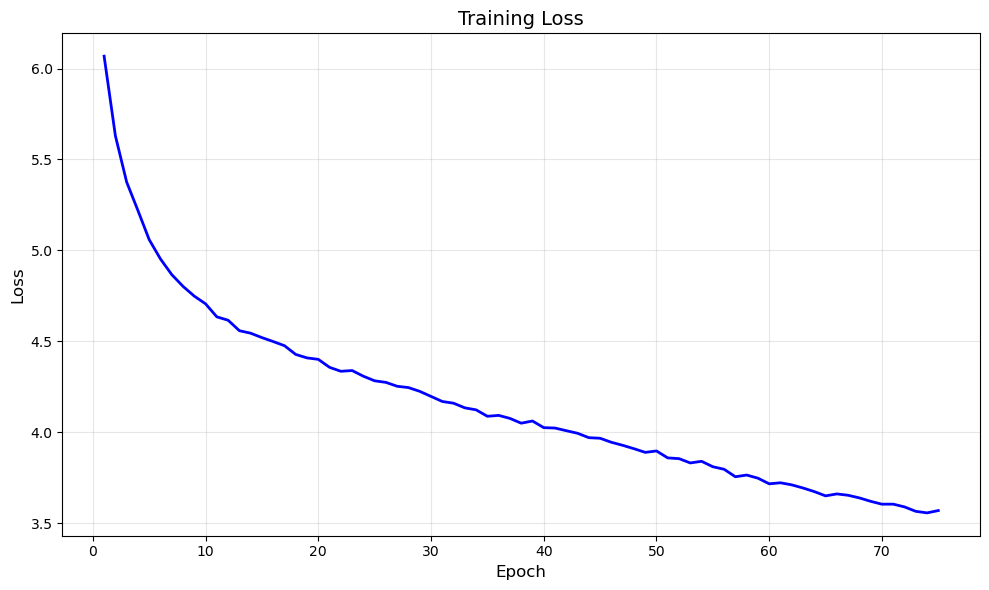

In [17]:
# Figure 1: Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/training_loss.png', dpi=150)
plt.show()

训练目标 = SupCon Loss ✓

你的encoder参数通过最小化SupCon Loss来更新

梯度来自SupCon Loss

这是实际驱动模型学习的信号

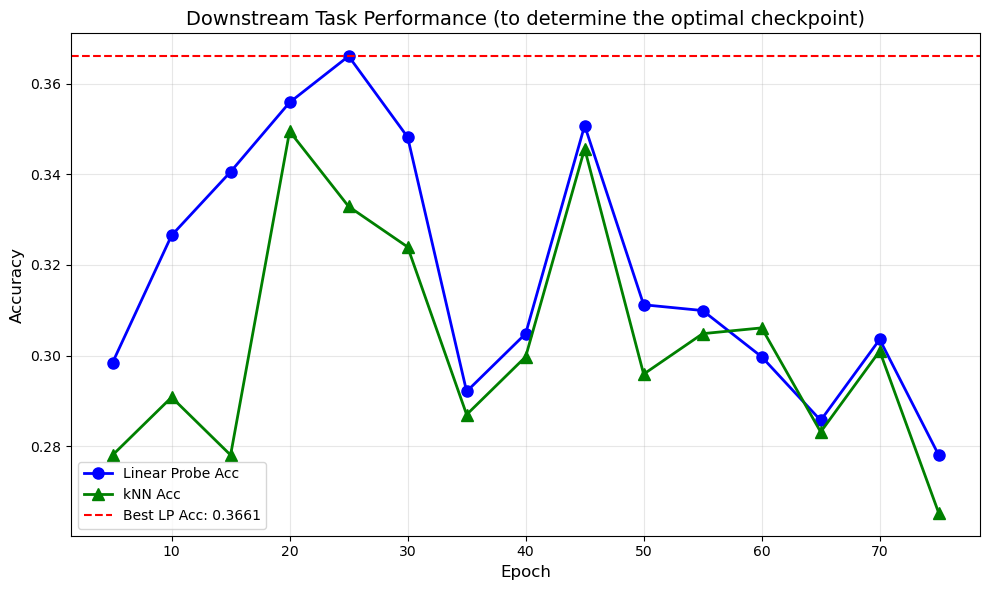

✅ This is the metric used to select the best checkpoint!


In [25]:
# Figure 2: Linear Probe Accuracy (用于选择最佳checkpoint的指标)
if eval_history:
    plt.figure(figsize=(10, 6))
    epochs = [e['epoch'] for e in eval_history]
    lp_accs = [e['linear_probe_acc'] for e in eval_history]
    knn_accs = [e['knn_acc'] for e in eval_history]
    
    plt.plot(epochs, lp_accs, 'bo-', linewidth=2, markersize=8, label='Linear Probe Acc')
    plt.plot(epochs, knn_accs, 'g^-', linewidth=2, markersize=8, label='kNN Acc')
    plt.axhline(y=best_lp_acc, color='r', linestyle='--', label=f'Best LP Acc: {best_lp_acc:.4f}')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Downstream Task Performance (to determine the optimal checkpoint)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{FIGURES_DIR}/downstream_performance.png', dpi=150)
    plt.show()
    print("✅ This is the metric used to select the best checkpoint!")

评估指标 = Downstream Task Accuracy ✓

- 用来判断encoder质量
- 决定是否保存checkpoint
- 但不参与encoder的训练！（encoder的训练目标只有一个： 目标是最小化SupCon Loss） 

🔬Linear Probe = 冻结encoder + 训练一个简单分类器 （Classifier本身不重要(用完就扔)， 只是用来测试encoder的表征质量）

Probe = 探针，用来"探测"encoder学到了什么

关键点:
- Classifier在训练集的embeddings上训练
- Accuracy在验证集的embeddings上评估
- Encoder在整个过程中是冻结的

训练目标 (SupCon):
  = 让同类OCT图像的embeddings接近
  = 让异类OCT图像的embeddings远离
  = 这是学习表征的方式

评估指标 (Linear Probe):
  = 测试学到的embeddings能否区分biomarkers
  = 如果能，说明embeddings质量好
  = 这些embeddings将来可以用于BCVA预测

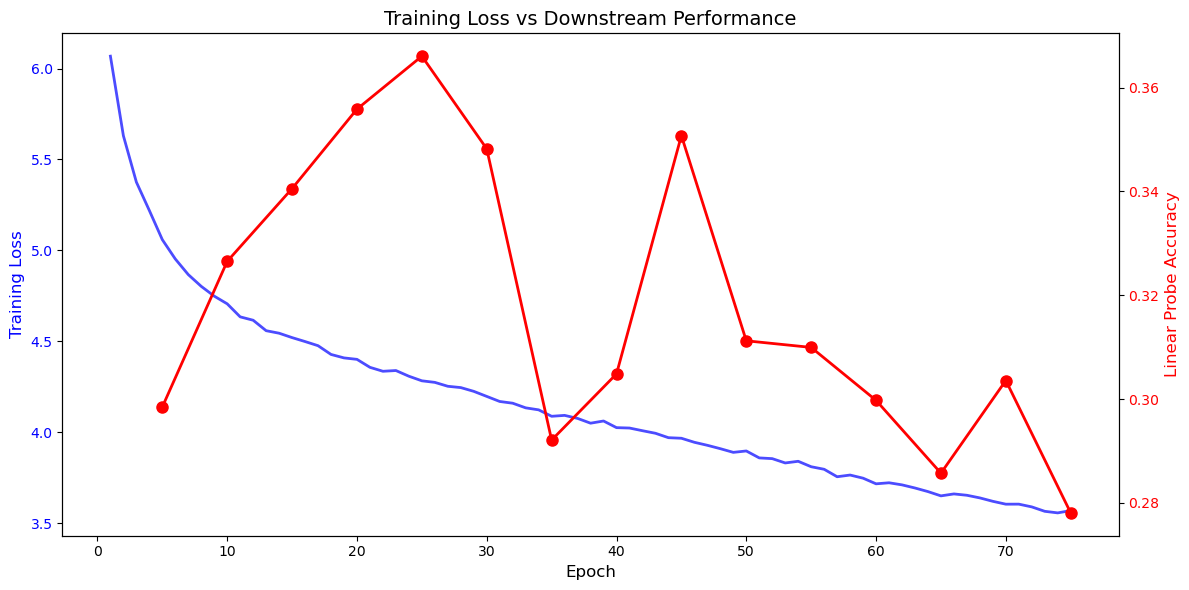

💡 Key insight: Lower SupCon loss doesn't guarantee better representations!


In [24]:
# Figure 3: Loss vs Downstream Performance Comparison
if eval_history:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Training loss (left y-axis)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', color='blue', fontsize=12)
    ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, alpha=0.7, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Downstream performance (right y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Linear Probe Accuracy', color='red', fontsize=12)
    epochs = [e['epoch'] for e in eval_history]
    lp_accs = [e['linear_probe_acc'] for e in eval_history]
    ax2.plot(epochs, lp_accs, 'ro-', linewidth=2, markersize=8, label='LP Acc')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title('Training Loss vs Downstream Performance', fontsize=14)
    fig.tight_layout()
    plt.savefig(f'{FIGURES_DIR}/loss_vs_downstream.png', dpi=150)
    plt.show()
    print("💡 Key insight: Lower SupCon loss doesn\'t guarantee better representations!")

---
## 11. Final Evaluation

In [20]:
# Load best model and final evaluation
print('='*70)
print('FINAL EVALUATION WITH BEST MODEL')
print('='*70)

best_ckpt = checkpoint_manager.load_best()
if best_ckpt:
    model.load_state_dict(best_ckpt['model_state_dict'])
    print(f"Loaded best model from epoch {best_ckpt['epoch'] + 1}")
    print(f"Best Linear Probe Accuracy: {best_ckpt['best_lp_acc']:.4f}")

# Final evaluation
final_result = evaluate_representation_quality(model, train_eval_loader, val_loader, device)
print(f"\nFinal Metrics:")
print(f"  Linear Probe Accuracy: {final_result['linear_probe_acc']:.4f}")
print(f"  kNN Accuracy: {final_result['knn_acc']:.4f}")
if final_result['auroc']:
    print(f"  AUROC: {final_result['auroc']:.4f}")

# Save final metrics
final_metrics = {
    'best_epoch': best_ckpt['epoch'] + 1 if best_ckpt else None,
    'best_linear_probe_acc': best_lp_acc,
    'final_linear_probe_acc': final_result['linear_probe_acc'],
    'final_knn_acc': final_result['knn_acc'],
    'final_auroc': final_result['auroc'],
    'total_epochs_trained': len(train_losses),
    'early_stopped': early_stopping.early_stop,
    'config': {
        'temperature': TEMPERATURE,
        'projection_dim': PROJECTION_DIM,
        'projection_dropout': PROJECTION_DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'use_hybrid_loss': USE_HYBRID_LOSS,
        'simclr_weight': SIMCLR_WEIGHT if USE_HYBRID_LOSS else None,
    }
}

with open(f'{OUTPUT_DIR}/final_metrics.json', 'w') as f:
    json.dump(final_metrics, f, indent=2)
print(f"\nMetrics saved to {OUTPUT_DIR}/final_metrics.json")

FINAL EVALUATION WITH BEST MODEL
Loaded best model from epoch 26
Best Linear Probe Accuracy: 0.3661

Final Metrics:
  Linear Probe Accuracy: 0.3661
  kNN Accuracy: 0.3329

Metrics saved to ./supcon_output_v3/final_metrics.json


---
## 12. Save Encoder

In [21]:
# Save the encoder
encoder_path = f'{OUTPUT_DIR}/oct_encoder_supcon_v3.pth'
torch.save(model.encoder.state_dict(), encoder_path)
print(f'\nEncoder saved to: {encoder_path}')

# Save config
config = {
    'embedding_dim': EMBEDDING_DIM,
    'projection_dim': PROJECTION_DIM,
    'temperature': TEMPERATURE,
    'weight_decay': WEIGHT_DECAY,
    'use_hybrid_loss': USE_HYBRID_LOSS,
    'simclr_weight': SIMCLR_WEIGHT,
    'best_linear_probe_acc': best_lp_acc,
    'selected_biomarkers': SELECTED_BIOMARKERS,
    'train_samples': len(train_df),
    'val_samples': len(val_df),
}

with open(f'{OUTPUT_DIR}/training_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print(f'Config saved to: {OUTPUT_DIR}/training_config.json')


Encoder saved to: ./supcon_output_v3/oct_encoder_supcon_v3.pth
Config saved to: ./supcon_output_v3/training_config.json


Computing t-SNE visualization...


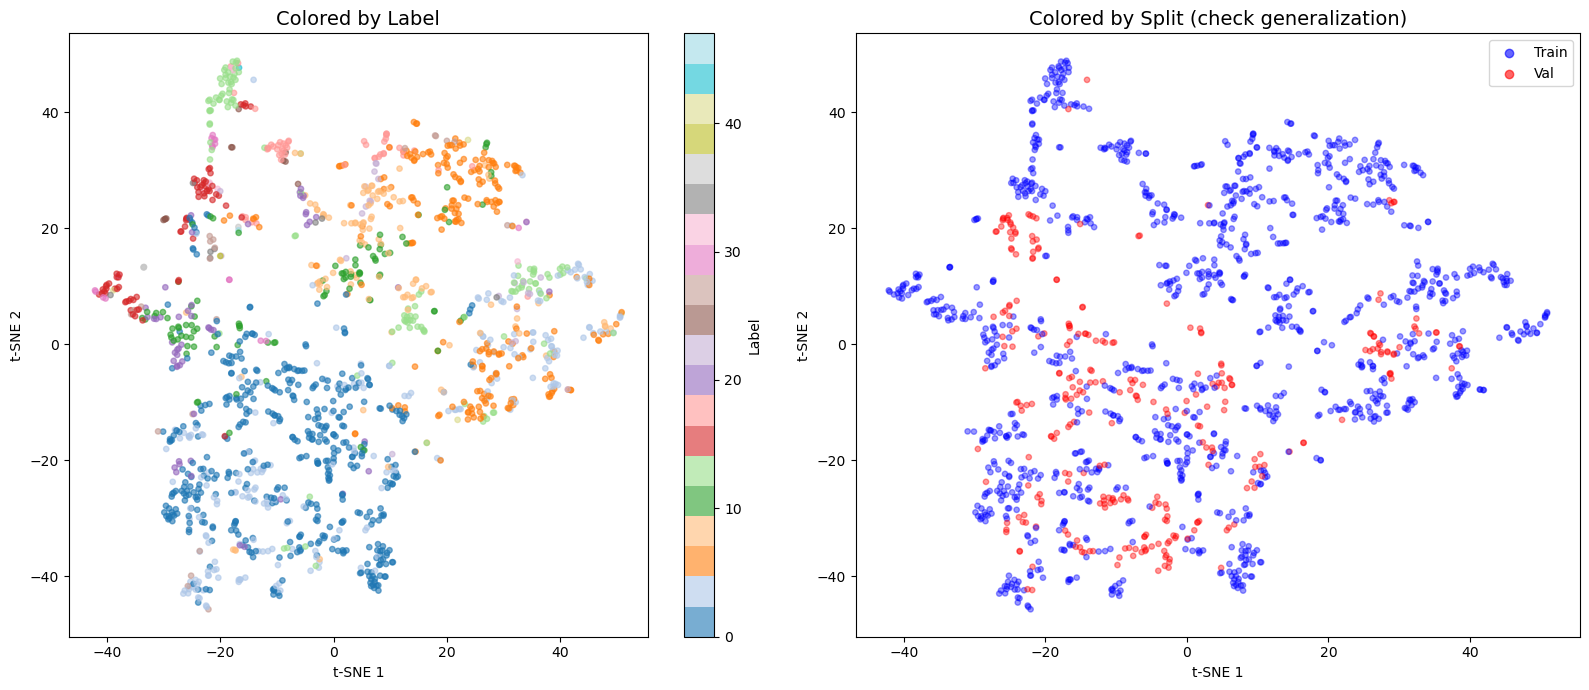

Figure saved: ./supcon_output_v3\figures/embedding_tsne_final.png


In [26]:
# t-SNE Visualization of Best Model's Embeddings
from sklearn.manifold import TSNE

print("Computing t-SNE visualization...")
train_emb, train_labels = extract_embeddings(model, train_eval_loader, device)
val_emb, val_labels = extract_embeddings(model, val_loader, device)

# Combine for visualization
all_emb = np.vstack([train_emb, val_emb])
all_labels = np.concatenate([train_labels, val_labels])
all_split = np.array(['Train']*len(train_emb) + ['Val']*len(val_emb))

# Subsample if needed
max_samples = 1500
if len(all_emb) > max_samples:
    idx = np.random.choice(len(all_emb), max_samples, replace=False)
    all_emb = all_emb[idx]
    all_labels = all_labels[idx]
    all_split = all_split[idx]

tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
emb_2d = tsne.fit_transform(all_emb)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# By label
scatter1 = axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1], c=all_labels, cmap='tab20', alpha=0.6, s=15)
axes[0].set_title('Colored by Label', fontsize=14)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0], label='Label')

# By split
colors = ['blue' if s == 'Train' else 'red' for s in all_split]
axes[1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, alpha=0.4, s=15)
axes[1].scatter([], [], c='blue', label='Train', alpha=0.6)
axes[1].scatter([], [], c='red', label='Val', alpha=0.6)
axes[1].set_title('Colored by Split (check generalization)', fontsize=14)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/embedding_tsne_final.png', dpi=150)
plt.show()
print(f"Figure saved: {FIGURES_DIR}/embedding_tsne_final.png")

t-SNE 可视化 🎨

左图 (按标签着色):

✅ 形成了8-12个清晰的cluster
✅ 相似biomarker组合在空间上相近
✅ 有渐变过渡，不是完全隔离（好事！）

右图 (按Train/Val着色) - 最重要:

✅ 训练和验证样本完全混合 - 这是泛化良好的最直接证据！
✅ 没有空间分离，说明模型没有记住训练集特殊性
✅ 每个cluster都包含蓝色和红色点，分布均匀

---
## Summary

### 核心改进 (解决过拟合):
1. ✅ **用Linear Probe/kNN评估选择checkpoint** - 而不是SupCon loss
2. ✅ **Early Stopping** - 基于downstream performance
3. ✅ **混合损失** - SupCon + SimCLR防止label过拟合
4. ✅ **降低锐度** - temperature 0.07→0.2
5. ✅ **增强正则化** - dropout, 更大weight decay, 更强augmentation

### 输出文件:
- `oct_encoder_supcon_v3.pth` - 最佳encoder权重
- `training_config.json` - 训练配置
- `final_metrics.json` - 最终评估指标
- `figures/` - 所有可视化图表

### 关键 insight:
- **SupCon validation loss 不能反映表示质量**
- 应该用 **linear probe accuracy** 或 **kNN accuracy** 来评估和选择模型
- 小数据集上，early stopping 至关重要